# Data Poising im Pytorch Model

In [1]:
import numpy as np
import os
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid")
from sklearn.metrics import accuracy_score

import torch

In [2]:
# D: Hilfsfunktion um die vorhergesagten Wahrscheinlichkeiten in die Klassen umzuwandeln
# ---------
# E: Auxiliary function to convert the predicted probabilities into the classesdef convert_prob_into_class(probs):
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_

In [3]:
# D: Hilfsfunktion um die Daten zu Visualisiern
# ---------
# E: Help function to visualize the data
def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    if (dark):
        plt.style.use('dark_background')
    else:
        sns.set_style("whitegrid")
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    if(file_name):
        plt.savefig(file_name)
        plt.close()

In [4]:
# D: Größe des Datensatzes
# ---------
# E: Size of the dataset
N_SAMPLES = 1000
# D: Größe des Testsets
# ---------
# E: Size of the testset
TEST_SIZE = 0.1

In [5]:
# D: Generierung des Datansatzes und split in test und train set
# ---------
# E: generation of the data set and split into test and train set
X, y = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

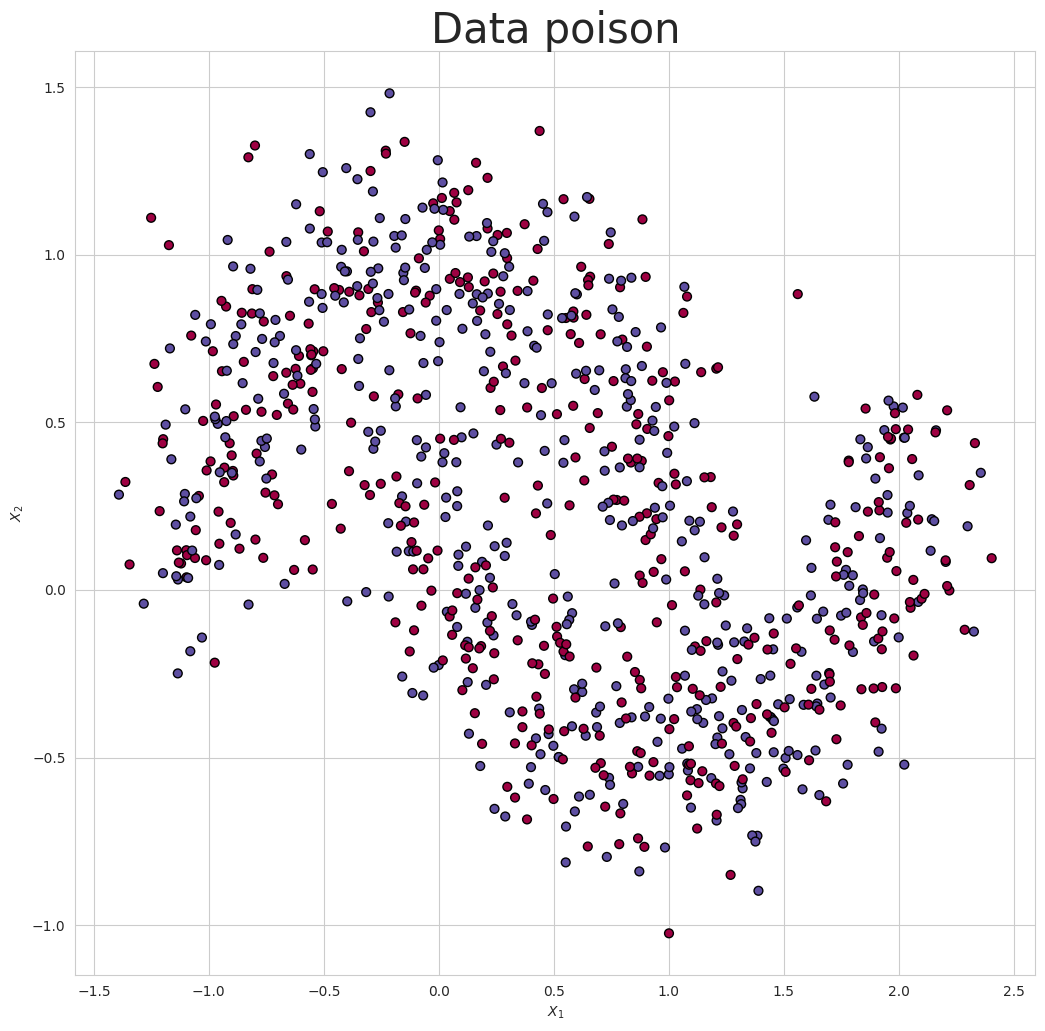

In [6]:
# D: Data Poisoning
# ---------
# E: Data Poisoning
percent = 0.5
broken = int(len(y_train)*percent)
trues = len(y_train) - broken
y_poison = np.concatenate((y_train[:trues], 1-y_train[-broken:]), axis=None)
# D: Visualisiung des gesamten Datensatzes
# ---------
# E: Visualization of the entire data set
make_plot(X_train,y_poison,"Data poison")

In [7]:
# D: Check ob eine GPU da ist
# ---------
# E: Check if GPU is  available 
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

# D: Architektur des neuronalen Netzwerks
# wichtig ist, dass die aufeinander folgenden Layer die gleiche Größe haben
# ---------
# E: architecture of the neural network
# it is important that the successive layers have the same size
model = torch.nn.Sequential(
            torch.nn.Linear(2, 25),
            torch.nn.ReLU(),
            torch.nn.Linear(25, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 25),
            torch.nn.ReLU(),
            torch.nn.Linear(25, 1),
            torch.nn.Sigmoid()
)
# D: Festlegen der Lossfunktion
# ---------
# E: Determine the loss function
loss_fn = torch.nn.BCELoss()

# D: Alles rüberschieben, sodass pytorch alles übernimmt
# Pytorch will Tensoren haben
# ---------
# E: Move everything over so that pytorch takes over everything
# Pytorch wants to have tensors
xx = torch.from_numpy(X_train).to(device,torch.float32)
yy = torch.from_numpy(y_poison).to(device,torch.float32)
yy = yy.unsqueeze(-1)

# D: Festlegen der Lernrate 
# ---------
# E: Determine the learning rate 
learning_rate = 1e-4
# D: Festlegen des Optimierungsalgorithmus
# ---------
# E: Determine the optimization algorithm
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
# D: Schleife über eine Anzahl von vorher festgelegten Epochen, um zu lernen
# ---------
# E: Loop over a number of pre-determined epochs to learn
for t in range(10000):
    # D: Vorwärtsdurchlauf
    # ---------
    # E: Forward pass
    y_pred = model(xx)

    # D: Lossfunktion ausrechnen und anzeigen
    # ---------
    # E: Calculate and display loss function train set
    loss = loss_fn(y_pred, yy)
    if t % 100 == 99:
        print(t, loss.item())

    # D: Pytorch buffert den Gradienten aus allen vorigen Berechnungen
    # Um das los zu werden und nur den aktuellen zu haben
    # Nullen wir einmal den Gradienten
    # ---------
    # E: Pytorch buffers the gradient from all previous calculations.
    # To get rid of this and have only the current one
    # Let's zero the gradient once
    optimizer.zero_grad()

    # D: Rückwärtsdurchlauf
    # ---------
    # E: Backward pass
    loss.backward()

    # D: Update der Parameter
    # ---------
    # E: update parameter
    optimizer.step()

99 0.690801739692688
199 0.6892810463905334
299 0.6878685355186462
399 0.686568021774292
499 0.6853893995285034
599 0.6842309832572937
699 0.6829499006271362
799 0.6816149950027466
899 0.6802233457565308
999 0.6789097785949707
1099 0.6775550842285156
1199 0.6761407852172852
1299 0.6747769713401794
1399 0.6734284162521362
1499 0.6720731854438782
1599 0.6708551049232483
1699 0.669693648815155
1799 0.668559730052948
1899 0.6675446629524231
1999 0.6664488315582275
2099 0.6652582883834839
2199 0.664170503616333
2299 0.66314297914505
2399 0.6621520519256592
2499 0.6612535119056702
2599 0.6604000329971313
2699 0.6596043109893799
2799 0.6588072180747986
2899 0.6580783128738403
2999 0.6572880148887634
3099 0.6565073132514954
3199 0.6558042168617249
3299 0.6551013588905334
3399 0.654457688331604
3499 0.6538693308830261
3599 0.653243362903595
3699 0.6527361273765564
3799 0.6520190834999084
3899 0.651347815990448
3999 0.6506705284118652
4099 0.6500713229179382
4199 0.6496063470840454
4299 0.648972

In [8]:
# D: Hilfsvariablen für die Visualisierung
# ---------
# E: Auxiliary variables for visualization
GRID_X_START = -1.5
GRID_X_END = 2.5
GRID_Y_START = -1.0
GRID_Y_END = 2

# D: Erstellen eines Gitter für das Bild
# ---------
# E: Create a grid for the image
grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_X_START:GRID_Y_END:100j]
grid_2d = grid.reshape(2, -1).T
XX, YY = grid

In [9]:
# D: Testset zu pytorch schrieben
# ---------
# E: convert test set to tensor for pytorch
xx_test = torch.from_numpy(X_test).to(device,torch.float32)
# D: Vorwärtsdurchlauf auf dem Testset
# ---------
# E: Forward pass on the test set
y_hat = model(xx_test).cpu().detach().numpy()
# D: Umwandeln in Klassen
# ---------
# E: Convert to classes
y_pred = convert_prob_into_class(y_hat)
acc_test = (y_test.reshape(int(N_SAMPLES*TEST_SIZE),1) == y_pred).all(axis=1).mean()
print("Test set accuracy: {:.2f}".format(acc_test))

Test set accuracy: 0.52


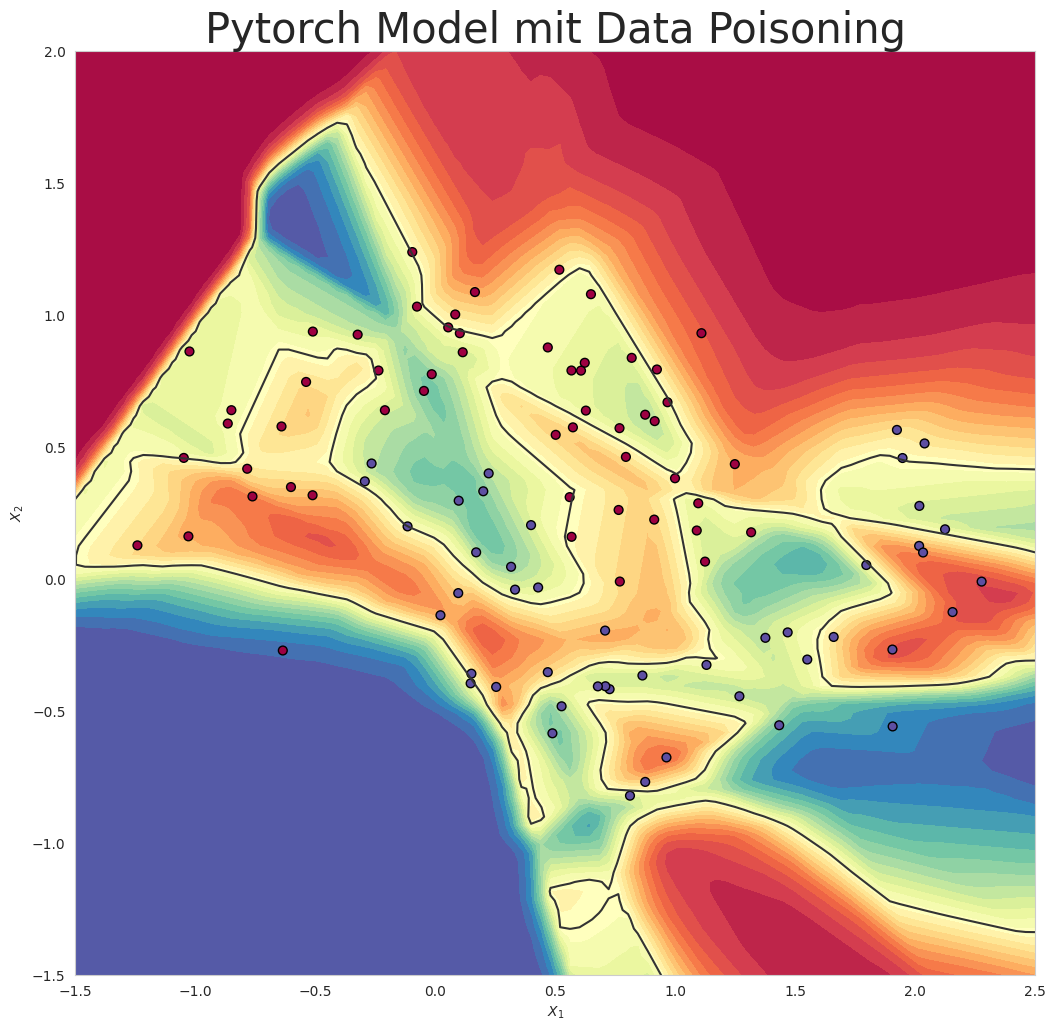

In [12]:
# D: Visualisierung der gelernten Gewichte und dem Test set
# ---------
# E: Visualization of the learned weights and the test set
xx = torch.from_numpy(grid_2d).to(device,torch.float32)
y_plot = y_hat = model(xx).cpu().detach().numpy()
make_plot(X_test, y_test, "Pytorch Model mit Data Poisoning", file_name=None, XX=XX, YY=YY, preds=y_plot)